In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/")
from sklearn.cluster import DBSCAN, HDBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dic = torch.load("/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/test/showers_df_evaluation/graphs_all_hdb/0_0_0.pt", map_location='cpu')


In [3]:
betas  = torch.sigmoid(dic["graph"].ndata["beta"])
X  = dic["graph"].ndata["coords"]
clustering_mode = "clustering_normal"
# if clustering_mode == "clustering_normal":
# clustering = get_clustering(betas,X)
# map_from = list(np.unique(clustering))
# cluster_id = map(lambda x: map_from.index(x), clustering)
# clustering_ordered = torch.Tensor(list(cluster_id)).long()
# if torch.unique(clustering)[0] != -1:
#     clustering = clustering_ordered + 1
# else:
#     clustering = clustering_ordered
# clustering = np.reshape(clustering, (-1))
# clustering = torch.Tensor(clustering).long()
# elif clustering_mode == "dbscan":
db = HDBSCAN(min_cluster_size=8, min_samples=8, cluster_selection_epsilon=0.05).fit(X)
labels_hdb = db.labels_ +1
labels_hdb = np.reshape(labels_hdb, (-1))
labels_hdb = torch.Tensor(labels_hdb).long()

# labels_pandora = dic["graph"].ndata["pandora_cluster"].long()
# labels_pandora = labels_pandora+1
# map_from = list(np.unique(labels_pandora))
# cluster_id = map(lambda x: map_from.index(x), labels_pandora)
# labels_pandora = torch.Tensor(list(cluster_id)).long()
# print(dic["part_true"][:,5])
from src.layers.inference_oc_tracks import match_showers, generate_showers_data_frame
labels = labels_hdb
model_output = torch.cat((dic["graph"].ndata["coords"], dic["graph"].ndata["beta"].view(-1,1)), dim=1)
particle_ids = torch.unique(dic["graph"].ndata["particle_number"])
shower_p_unique = torch.unique(labels)
shower_p_unique, row_ind, col_ind, i_m_w, iou_matrix= match_showers(
    labels,
    dic,
    particle_ids,
    model_output,
    0,
    0,
    None,
)
df_event, number_of_showers_total = generate_showers_data_frame(
                labels,
                dic,
                shower_p_unique,
                particle_ids,
                row_ind,
                col_ind,
                i_m_w,
                number_of_showers_total=0,
                step=0,
                number_in_batch=0,
            )
print(df_event)




    reco_showers_E  true_showers_E  pred_showers_E  e_pred_and_truth
0             54.0        1.481437            54.0              54.0
1             48.0        1.871253            48.0              48.0
2             64.0        6.622914            64.0              64.0
3             45.0        2.206414            45.0              45.0
4             71.0        2.472970            70.0              70.0
5             38.0        1.503932            38.0              38.0
6             53.0        7.976103            53.0              53.0
7             60.0       15.701566            60.0              60.0
8             37.0        2.592102            37.0              37.0
9             42.0        2.449077            42.0              42.0
10            50.0        1.920039            50.0              50.0
11            52.0        2.798701            52.0              52.0
12            34.0        0.781206            34.0              34.0
13            64.0        2.303961

In [6]:
import onnx
onnx_model = onnx.load("/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/test/model_1.onnx")
onnx.checker.check_model(onnx_model)

In [4]:
pos_hits_xyz = dic["graph"].ndata["pos_hits_xyz"]
hit_type = dic["graph"].ndata["hit_type"].view(-1, 1)
vector = dic["graph"].ndata["vector"]
input_data = torch.cat((pos_hits_xyz, hit_type, vector), dim=1)


In [33]:
translation_vector = vector
batch_shape = translation_vector.shape[0]
multivector = torch.zeros(
    batch_shape, 16, dtype=translation_vector.dtype, device=translation_vector.device
)

# Embedding into trivectors
multivector[:, 0] = 1.0  # scalar
multivector[:, 5:8] = (
    -0.5 * translation_vector[:, :]
) 

In [36]:
multivector.shape

torch.Size([1451, 16])

In [32]:
non_scalar_components

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [22]:
multivector

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
import onnxruntime as ort

ort.set_default_logger_severity(0)

so = ort.SessionOptions()
print(so.inter_op_num_threads)
print(so.intra_op_num_threads)
print("starting to load")
ort_session = ort.InferenceSession(
    "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/test/model.onnx",
    providers=["CPUExecutionProvider"],
)
print("finished loading")

In [ ]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(input_data)}
ort_outs = ort_session.run(None, ort_inputs)


In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [10]:
import onnxruntime

onnx_input = onnx_model.adapt_torch_inputs_to_onnx(input_data)
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

AttributeError: adapt_torch_inputs_to_onnx

In [ ]:
import onnxruntime

onnx_input = onnx_program.adapt_torch_inputs_to_onnx(torch_input)
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

ort_session = onnxruntime.InferenceSession("./my_image_classifier.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

onnxruntime_outputs = ort_session.run(None, onnxruntime_input)


In [15]:
# unique_pd = torch.unique(dic["graph"].ndata['particle_number'])
# for jj, i in enumerate(unique_pd):
#     mask = dic["graph"].ndata['particle_number'].view(-1) ==i
#     ind = torch.argmax(betas[mask])
#     part_n = dic["graph"].ndata['particle_number'][mask][0]-1
#     print(jj, dic["part_true"][:,5][part_n.long()],torch.max(betas[mask]),torch.max(torch.norm(X[mask]-X[mask][ind], dim=-1)))

In [6]:
# y =dic["part_true"]
# parents = y[:, -1]
# particle_ids = y[:, 4]
# change_pairs = []
# for indx, i in enumerate(parents):
#     if torch.sum(particle_ids == i) > 0:
#         change_pairs.append([parents[indx], particle_ids[indx]])
# print("change_pairs", change_pairs)


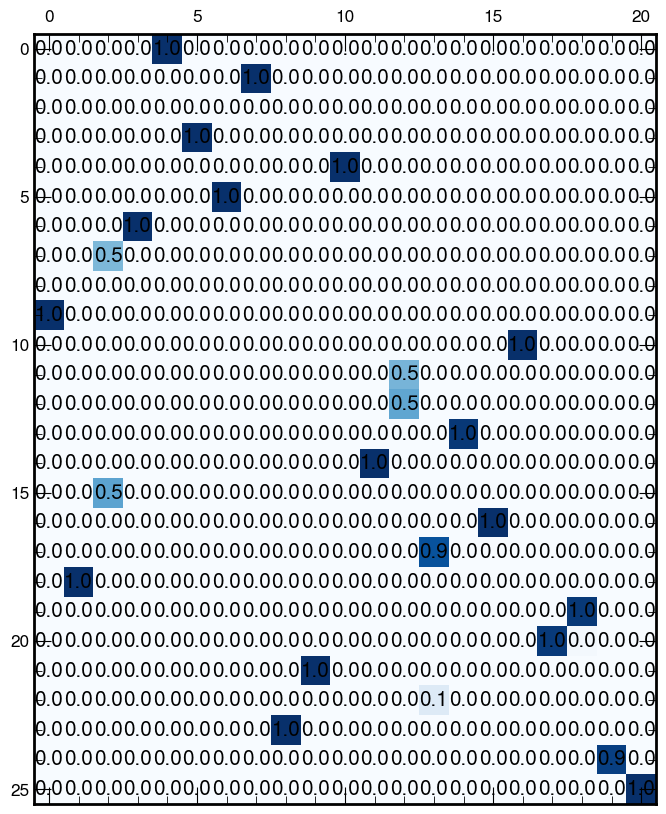

In [15]:

iou_matrix = torch.transpose(iou_matrix[1:, :], 1, 0)
fig, ax = plt.subplots()
iou_matrix = iou_matrix.detach().cpu().numpy()
ax.matshow(iou_matrix, cmap=plt.cm.Blues)
for i in range(0, iou_matrix.shape[1]):
    for j in range(0, iou_matrix.shape[0]):
        c = np.round(iou_matrix[j, i], 1)
        ax.text(i, j, str(c), va="center", ha="center")

# id_p = 11
# a = torch.sum((dic["graph"].ndata["particle_number"] == id_p)  * (torch.argmax(dic["graph"].ndata["hit_type"], dim=1)==0))
# b = torch.sum((dic["graph"].ndata["particle_number"] == id_p)  * (torch.argmax(dic["graph"].ndata["hit_type"], dim=1)==1))
# c = torch.sum((dic["graph"].ndata["particle_number"] == id_p)  * (torch.argmax(dic["graph"].ndata["hit_type"], dim=1)==2))
# d = torch.sum((dic["graph"].ndata["particle_number"] == id_p)  * (torch.argmax(dic["graph"].ndata["hit_type"], dim=1)==3))
# print(a,b,c,d)

In [6]:
from src.logger.plotting_tools import shuffle_truth_colors
pp = [1]
mask =  (dic["graph"].ndata['particle_number'].view(-1)!=-1)
for i in pp:
    mask = mask +  (dic["graph"].ndata['particle_number'].view(-1) ==i)
#mask =(dic["graph"].ndata['particle_number'].view(-1) !=-1) #+(dic["graph"].ndata['particle_number'].view(-1) ==25)   + (dic["graph"].ndata['particle_number'].view(-1) ==20)+ (dic["graph"].ndata['particle_number'].view(-1) ==12)+ (dic["graph"].ndata['particle_number'].view(-1) ==15)
tidx =  1*(dic["graph"].ndata['particle_number'].view(-1,1)[mask])# +1*(dic["graph"].ndata['particle_number_nomap'].view(-1,1)[mask]==189)#(labels_pandora.view(-1,1))
features = torch.sigmoid(dic["graph"].ndata["beta"][mask]).view(-1,1)
X =dic["graph"].ndata["pos_hits_xyz"][mask]#dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [72]:
torch.sum(dic["graph"].ndata['hit_type'][mask]==2),torch.sum(dic["graph"].ndata['hit_type'][mask]==3)

(tensor(58), tensor(193))

In [78]:
ecal_hits = scatter_add(1*(dic["graph"].ndata['hit_type']==2), dic["graph"].ndata['particle_number'].view(-1).long())
hcal_hits = scatter_add(1*(dic["graph"].ndata['hit_type']==3), dic["graph"].ndata['particle_number'].view(-1).long())

In [82]:
weights = torch.ones_like(dic["graph"].ndata['hit_type'])

In [93]:
print(ecal_hits)
print(hcal_hits)
weight_ecal_per_object = 1.0*ecal_hits.clone()+1
weight_hcal_per_object = 1.0*ecal_hits.clone()+1
mask =(ecal_hits>2)*(hcal_hits>2)
weight_ecal_per_object[mask] = (ecal_hits+hcal_hits)[mask]/(2*ecal_hits)[mask]
weight_hcal_per_object[mask] = (ecal_hits+hcal_hits)[mask]/(2*hcal_hits)[mask]
print(weight_ecal_per_object)
print(weight_hcal_per_object)


tensor([  0,  58, 445,   0,   0,  85, 138,  77,  36,  41])
tensor([  0, 193,  78,   4, 109,   0,  58,   1,   0,   0])
tensor([ 1.0000,  2.1638,  0.5876,  1.0000,  1.0000, 86.0000,  0.7101, 78.0000,
        37.0000, 42.0000])
tensor([ 1.0000,  0.6503,  3.3526,  1.0000,  1.0000, 86.0000,  1.6897, 78.0000,
        37.0000, 42.0000])


In [92]:
2.1638*58+0.6503*193

251.00830000000002

In [11]:
dic["part_true"][:,5]


tensor([13.0880,  1.7113,  1.8285,  0.1050,  2.1278,  0.5404,  1.0237,  3.4199,
         1.0623,  0.6576,  0.9063,  0.2535,  0.3852,  0.8060,  8.1772,  5.2689,
         0.1015,  0.0384,  0.7845,  0.1765,  0.2769])

In [26]:
parents = dic["part_true"][:,-2]
print(parents)
particle_ids =  dic["part_true"][:, 4]
change_pairs = []
for indx, i in enumerate(parents):
    if torch.sum(particle_ids == i) > 0:
        change_pairs.append([parents[indx], particle_ids[indx]])
print(change_pairs)



tensor([ 24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  61.,  61.,  63.,
         65.,  66.,  66.,  68.,  69.,  70.,  72.,  77.,  80.,  67.,  67.,  67.,
        178.])
[[tensor(67.), tensor(176.)], [tensor(67.), tensor(177.)], [tensor(67.), tensor(178.)], [tensor(178.), tensor(179.)]]


In [25]:
particle_ids

tensor([ 62.,  64.,  67.,  71.,  73.,  75.,  78.,  79.,  81.,  84.,  85.,  86.,
         88.,  90.,  91.,  93.,  95.,  96.,  99., 105., 107., 176., 177., 178.,
        179.])

In [107]:
a = np.exp(np.arange(np.log(0.001), np.log(80), 0.5))

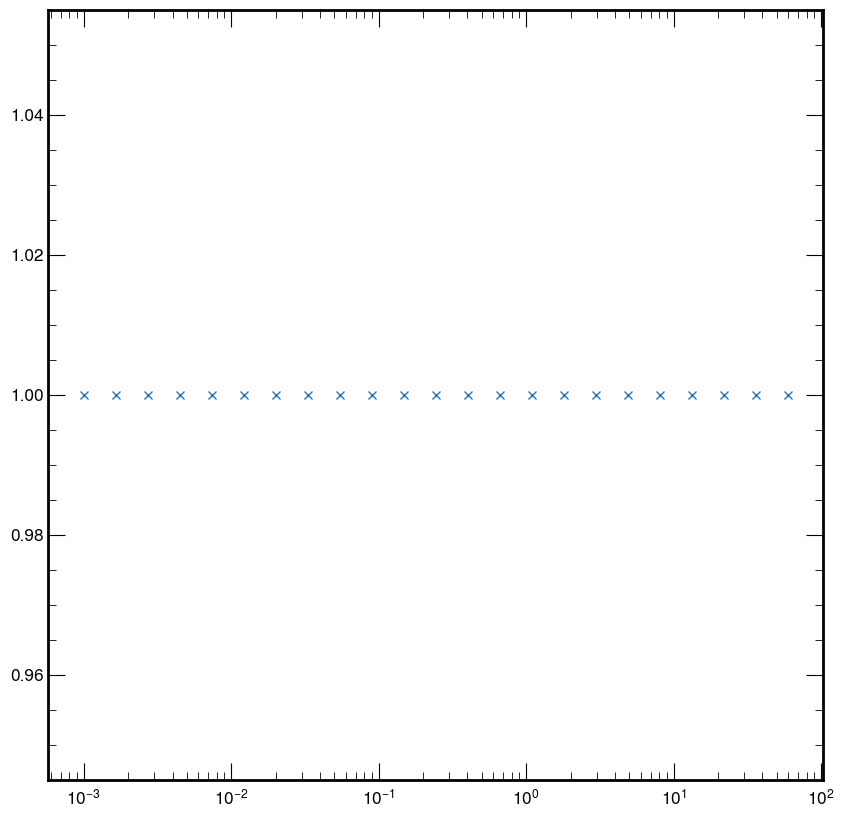

In [109]:
plt.plot(a,np.ones(len(a)),'x')
plt.xscale("log")

In [64]:
print(dic["part_true"][:,3])
print(dic["part_true"][:,4])
print(dic["part_true"][:,5])
print(dic["part_true"][:,6])

tensor([ 1.4387, 16.2788,  8.1231,  2.3531,  1.8258, 36.4957, 40.6092, 11.0805])
tensor([ 1.4319, 16.2788,  8.1231,  2.3531,  1.8258, 36.4836, 40.6092, 11.0805])
tensor([1.3957e-01, 1.2678e-03, 2.2820e-03, 1.8757e-04, 3.8206e-04, 9.3962e-01,
        5.0583e-03, 3.1222e-03])
tensor([ 211.,   22.,  -11.,   22., -211., 2112., -211.,   22.])


In [65]:
dic["graph"].ndata['particle_number']

tensor([7., 3., 5.,  ..., 7., 7., 1.])

In [21]:
from src.logger.plotting_tools import shuffle_truth_colors
mask =(dic["graph"].ndata['particle_number'].view(-1) !=-1) #   + (dic["graph"].ndata['particle_number'].view(-1) ==6 ) 
tidx =  1*(dic["graph"].ndata['particle_number'].view(-1,1)[mask])#(labels_pandora.view(-1,1))
features = torch.sigmoid((dic["graph"].ndata["beta"])[mask])
X =dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [27]:
torch.exp(-1*torch.Tensor([5])),torch.exp(-1*torch.Tensor([10]))

(tensor([0.0067]), tensor([4.5400e-05]))

In [21]:
from src.logger.plotting_tools import shuffle_truth_colors
mask =(dic["graph"].ndata['particle_number'].view(-1) !=-1) #   + (dic["graph"].ndata['particle_number'].view(-1) ==6 ) 
tidx =  labels_pandora.view(-1,1)[mask]#(labels_pandora.view(-1,1))
features = (dic["graph"].ndata["e_hits"])[mask]
X =dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [97]:
freq_count_particles[number_of_particles_event] = freq_count_particles[number_of_particles_event]+1
freq_count_energy = freq_count_energy + torch.histogram(energy_particles,energy_event)[0]

In [106]:
from torch_scatter import scatter_max, scatter_add, scatter_mean
cluster_space_coords = g.ndata["pos_hits_xyz"]
object_index = g.ndata["particle_number"].view(-1)
x_alpha_sum = scatter_mean(
    cluster_space_coords,
    object_index.long(),dim=0
) 
nVs = x_alpha_sum[1:] / torch.norm(x_alpha_sum[1:], p=2, dim=-1, keepdim=True)
# compute cosine of the angles using dot product
cos_ij = torch.einsum('ij,pj->ip', nVs, nVs)
min_cos_per_particle = torch.min(torch.abs(cos_ij), dim=0)[0]
freq_count_angle = freq_count_angle + torch.histogram(min_cos_per_particle,angle_distribution)[0]

In [109]:
freq_count_angle

tensor([0., 2., 1., 0., 1., 1., 1., 0., 0., 0.])

tensor([[ 22.3746,   4.2995,  -4.4514],
        [ 22.9379,  24.1192, -11.1488],
        [ 21.6913,  -6.8498, -43.0122],
        [ 22.6319,  24.4839,  -3.7761]])

In [34]:
mask = dic["graph"].ndata["particle_number"] == 26
dic["graph"].ndata["particle_number_nomap"][mask]

tensor([237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.])

In [31]:
from torch_scatter import scatter_add, scatter_sum, scatter_min, scatter_max
coord = dic["graph"].ndata['pos_hits_xyz']
cluster_id = dic["graph"].ndata['particle_number']
min_x = scatter_min(coord[:, 0], cluster_id.long() - 1)[0]
min_y = scatter_min(coord[:, 1], cluster_id.long() - 1)[0]
min_z = scatter_min(coord[:, 2], cluster_id.long() - 1)[0]
max_x = scatter_max(coord[:, 0], cluster_id.long() - 1)[0]
max_z = scatter_max(coord[:, 2], cluster_id.long() - 1)[0]
max_y = scatter_max(coord[:, 1], cluster_id.long() - 1)[0]
diff_x = torch.abs(torch.abs(max_x) + torch.abs(min_x))
diff_y = torch.abs(torch.abs(max_y) + torch.abs(min_y))
diff_z = torch.abs(max_z - min_z)
print(diff_x)
print(diff_z)
mask_x = diff_x > 1600
mask_z = diff_z > 2800

tensor([1380.5227,  520.2003, 1608.8506,  843.0952,  559.4832, 1348.2191,
        1086.2991,  638.0980, 1093.8938, 1301.5480, 1375.5693,  501.4397,
        1126.8813, 1300.9928, 1473.2686,  376.2064, 1099.7385, 1416.8052,
        1106.4557,  966.0092, 1179.0588, 1546.3901, 1585.1561])
tensor([ 354.8687,  616.8201,  428.9179, 1881.5916,  990.9010, 1118.7372,
        1879.0288,  704.1495, 1158.4973,  429.6730,  969.8974,  695.9861,
        1266.7893, 1508.8146, 2041.9073, 2691.3696, 2627.1597, 2712.9558,
         893.2917, 1959.5400, 2116.6697,  956.1729, 1858.1315])


In [35]:
max_y[9],min_y[9]

(tensor(1440.0493), tensor(13.4809))

In [36]:
diff_y[8],diff_y[14]

(tensor(3454.1001), tensor(3285.2417))

In [150]:
store_image(label=False, cluster=False)
# store_image(label=True, cluster=False)
# store_image(label=False, cluster=False, pandora=True)

In [21]:
store_image(label=False, cluster=True)
store_image(label=True, cluster=True)
store_image(label=False, cluster=True, pandora=True)

In [28]:
from src.logger.plotting_tools import shuffle_truth_colors

def plot_iou_matrix(iou_matrix, image_path):
    iou_matrix = torch.transpose(iou_matrix[1:, :], 1, 0)
    fig, ax = plt.subplots()
    iou_matrix = iou_matrix.detach().cpu().numpy()
    ax.matshow(iou_matrix, cmap=plt.cm.Blues)
    for i in range(0, iou_matrix.shape[1]):
        for j in range(0, iou_matrix.shape[0]):
            c = np.round(iou_matrix[j, i], 1)
            ax.text(i, j, str(c), va="center", ha="center")
def store_image(label=False, cluster = False, pandora = False):
    if label:
        tidx = np.reshape(labels, (-1,1)) 
    elif pandora:
        tidx = np.reshape(labels_pandora, (-1,1))
    else:
        tidx = dic["graph"].ndata['particle_number'].view(-1,1)
    features =  dic["graph"].ndata["e_hits"]*200
    pos_hits =dic["graph"].ndata["pos_hits_xyz"]
    if cluster:
        pos_hits = X
    data = {
                "X": pos_hits[:, 0].view(-1, 1).detach().cpu().numpy(),
                "Y": pos_hits[:, 1].view(-1, 1).detach().cpu().numpy(),
                "Z": pos_hits[:, 2].view(-1, 1).detach().cpu().numpy(),
                "tIdx": tidx,
                "features": features.view(-1, 1).detach().cpu().numpy(),
            }
    hoverdict = {}
    # if hoverfeat is not None:
    #     for j in range(hoverfeat.shape[1]):
    #         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
    #     data.update(hoverdict)

    # if nidx is not None:
    #     data.update({"av_same": av_same})

    df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
    )
    df["orig_tIdx"] = df["tIdx"]
    # rdst = np.random.RandomState(1234567890)  # all the same
    # shuffle_truth_colors(df, "tIdx", rdst)

    # hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
    # if nidx is not None:
    #     hover_data.append("av_same")
    fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size="features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
    )
    fig.update_traces(marker=dict(line=dict(width=0)))
    if label and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label_0.html"
    elif pandora and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/pandora_label_0.html"
    elif label and cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label_cluster_0.html"
    elif not label and  cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label_cluster_0.html"
    else:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label_0.html"
    fig.write_html(path)